Oversampling > 2x suggested for reliable results in Fresnel propagation.


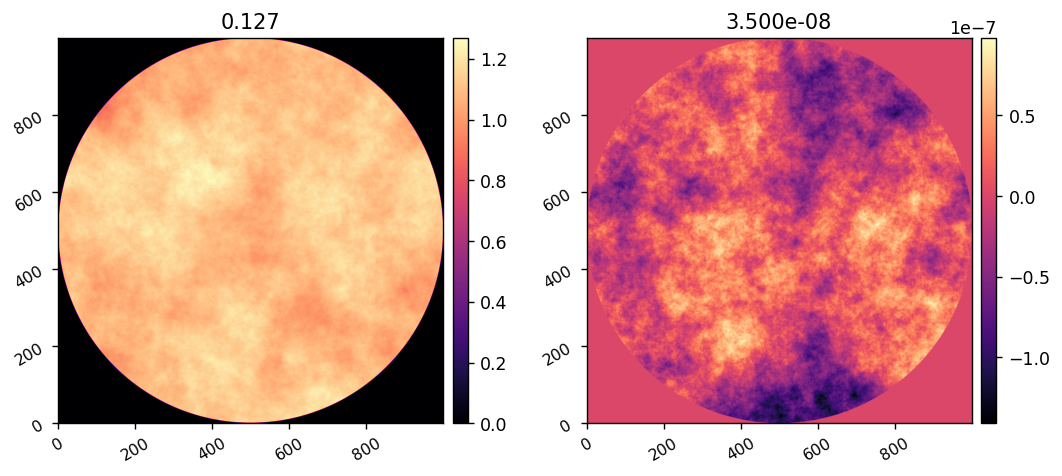

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = 650e-9/2/np.pi * xp.angle(WFE)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

In [2]:
10e-6**2 / (650e-9 * 0.1)

0.0015384615384615387

# Establish the forward model parameters.

In [3]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

Oversampling > 2x suggested for reliable results in Fresnel propagation.


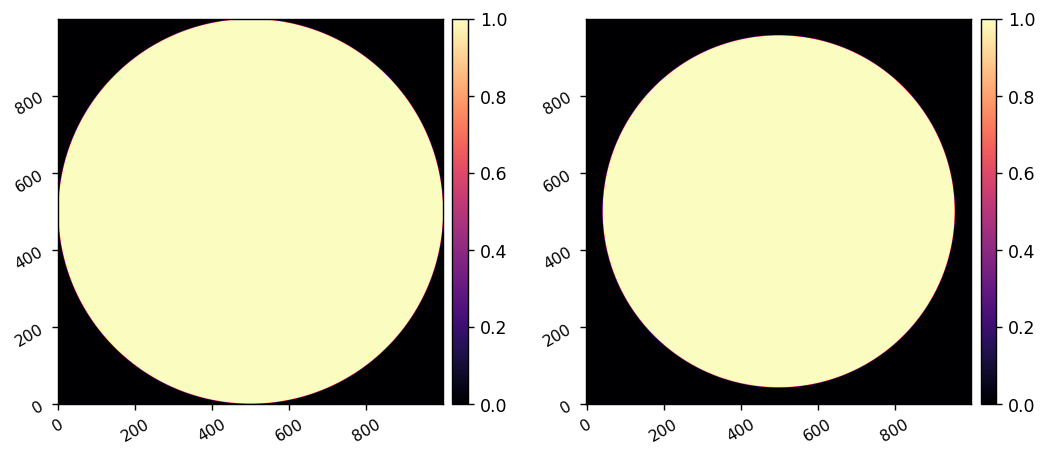

In [3]:
imshow2(m.APERTURE, m.LYOT, npix=m.npix)

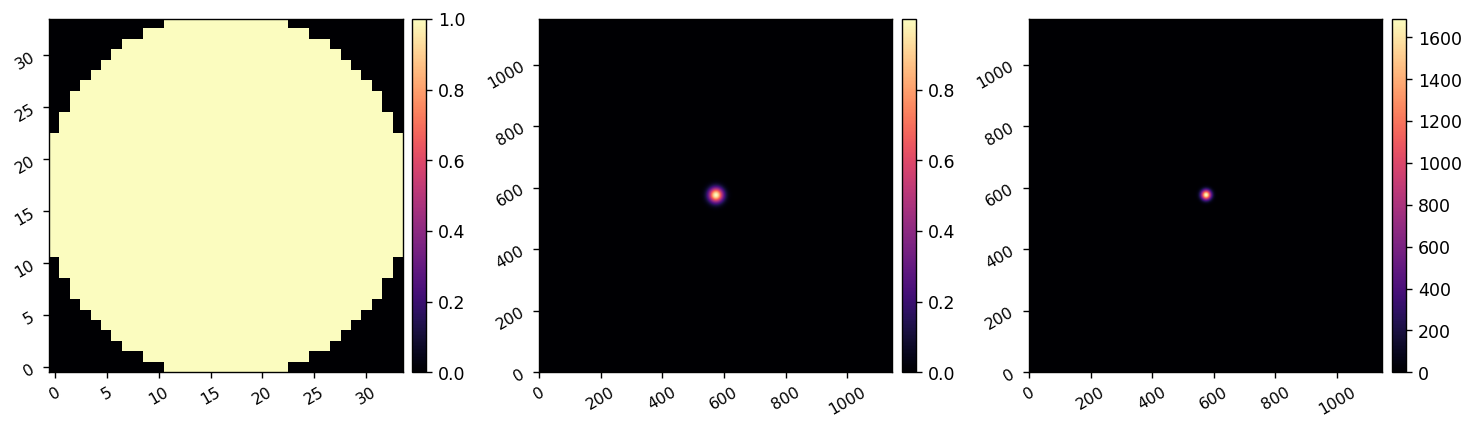

In [4]:
imshow3(m.dm_mask, m.inf_fun, xp.abs(m.inf_fun_fft))

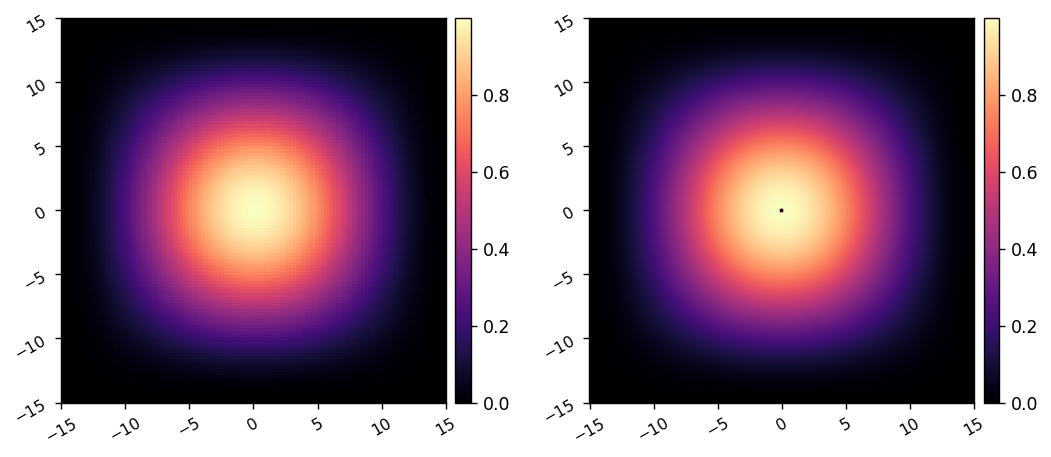

In [5]:
imshow2(m.lres_window, m.hres_window, npix1=m.lres_win_size,
        pxscl1=m.lres_sampling, pxscl2=m.hres_sampling)

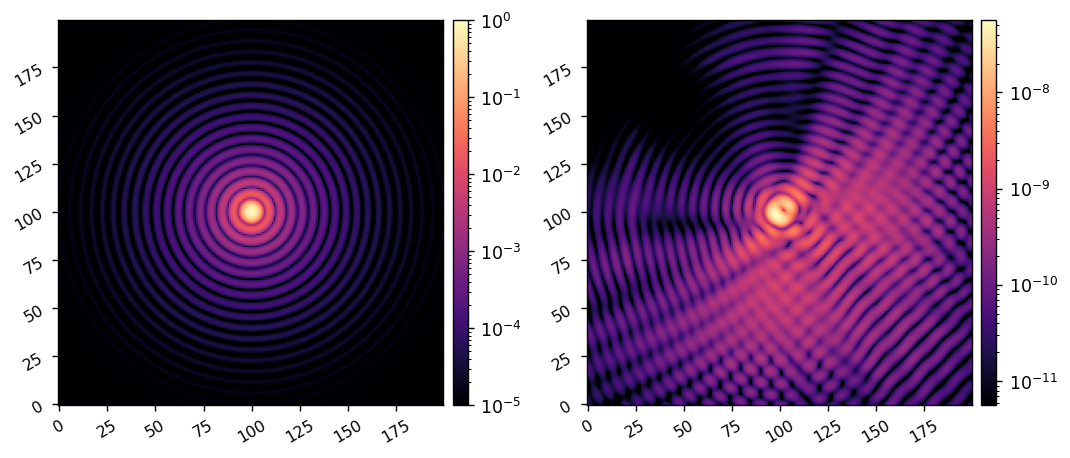

In [5]:
m.Imax_ref = 1
test_psf = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=False, use_wfe=False))**2
m.Imax_ref = xp.max(test_psf)
test_coro_im = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=True, use_wfe=False))**2
imshow2(test_psf/m.Imax_ref, test_coro_im, lognorm=True, vmin1=1e-5, vmin2=xp.max(test_coro_im)/1e4)

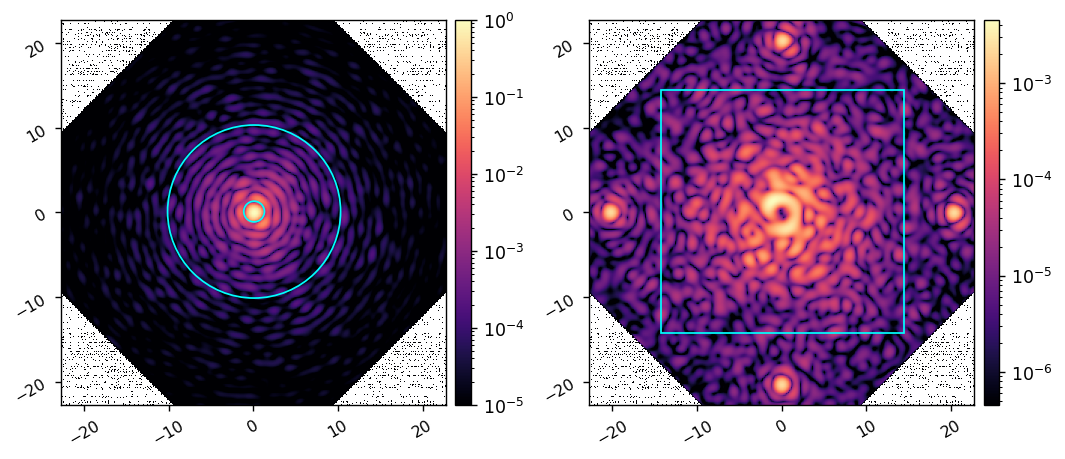

In [15]:
acts = np.zeros(m.Nacts)

waffle_command = 20e-9 * xp.ones((m.Nact,m.Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
acts = ensure_np_array(waffle_command[m.dm_mask]) 

m.npsf = 256
m.det_rotation = 45

m.Imax_ref = 1
ref_psf = xp.abs(m.forward(np.zeros(m.Nacts), use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow2(ref_psf/m.Imax_ref, ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)


# Test normal EFC

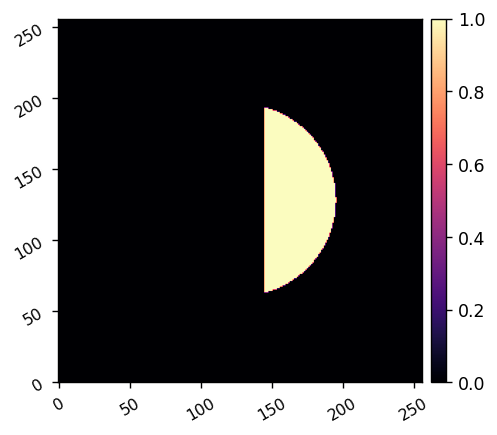

In [16]:
m.create_control_mask()
imshow1(m.control_mask)

In [17]:
reload(ad_efc)

poke_modes = ad_efc.create_poke_modes(m)

In [18]:
reload(ad_efc)

jac = ad_efc.compute_jacobian(m, poke_modes)


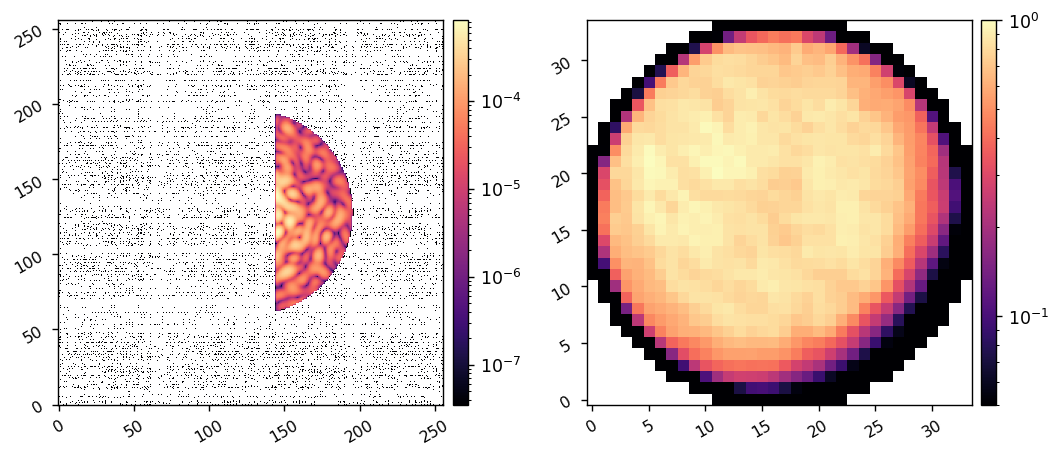

In [19]:
responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.sum(xp.square(xp.abs(responses.dot(poke_modes.reshape(m.Nacts, m.Nact**2)))), axis=0)).reshape(m.Nact,m.Nact)
dm_response /= dm_response.max()
imshow2(m.control_mask*ref_coro_im, dm_response, lognorm=True, vmin2=5e-2)

In [26]:
all_ims = []
all_efs = []
all_commands = []

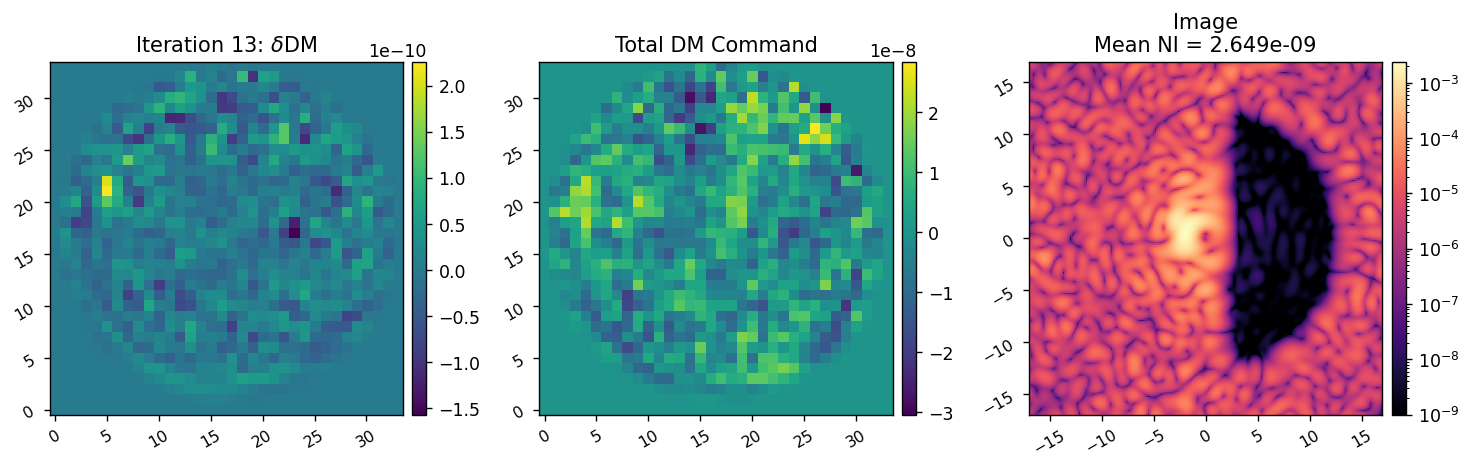

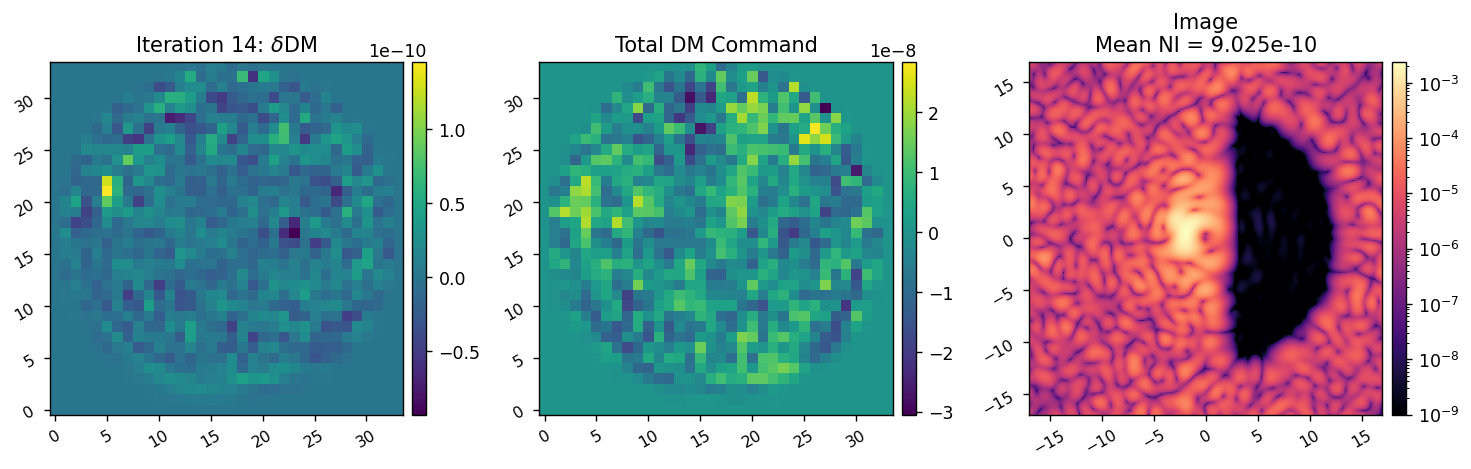

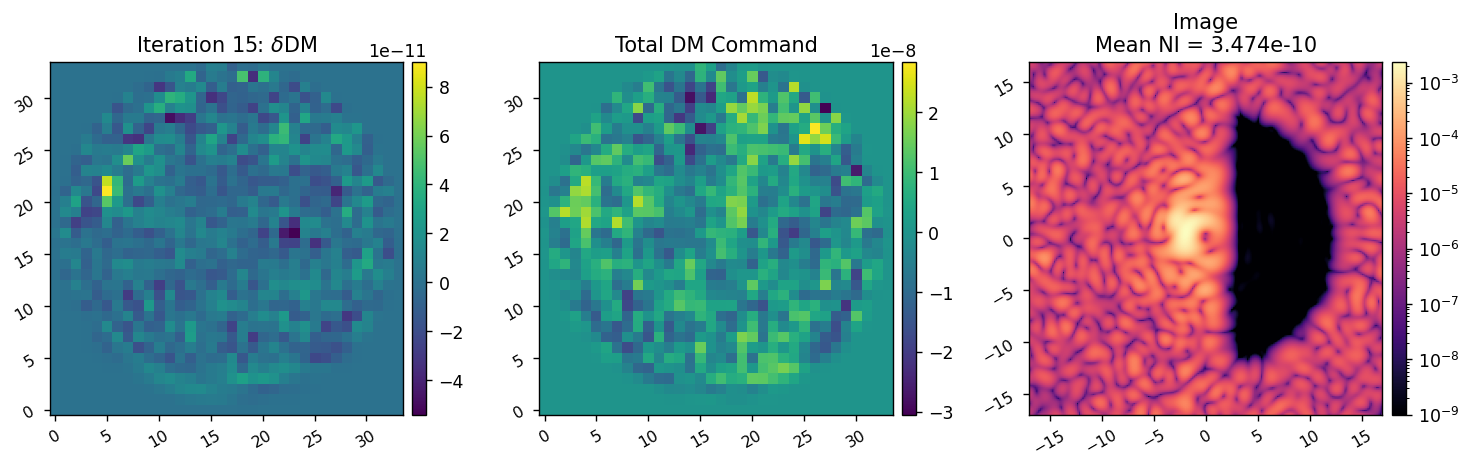

In [34]:
reload(ad_scoob)

cm = ad_scoob.beta_reg(jac, -2.5)
# cm = ad_scoob.beta_reg(jac, -4.5)

all_ims, all_efs, all_commands = ad_scoob.efc(m,
                                              cm, 
                                              Nitr=3, 
                                              nominal_command=all_commands[-1], 
                                              all_ims=all_ims, 
                                              all_efs=all_efs,
                                              all_commands=all_commands,
                                              )



# Test minimzation with L-BFGS-B

Oversampling > 2x suggested for reliable results in Fresnel propagation.


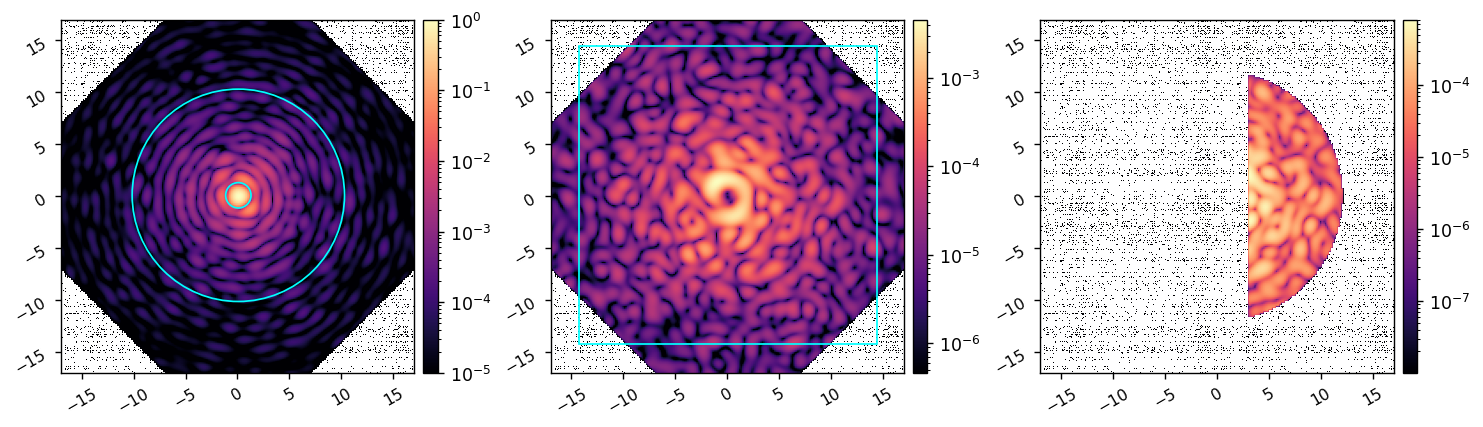

In [10]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE
m.det_rotation = 45
m.create_control_mask()

ref_psf = m.snap(np.zeros(m.Nacts), use_vortex=False, use_wfe=True)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = m.snap(np.zeros(m.Nacts), use_vortex=True, use_wfe=True)

imshow3(ref_psf/m.Imax_ref, ref_coro_im, m.control_mask*ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True,  vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

In [58]:
utils.save_fits('test_acts.fits', res.x)

Saved data to:  test_acts.fits


0.33452257679848796 0.0 0.33452257679848796 1.0


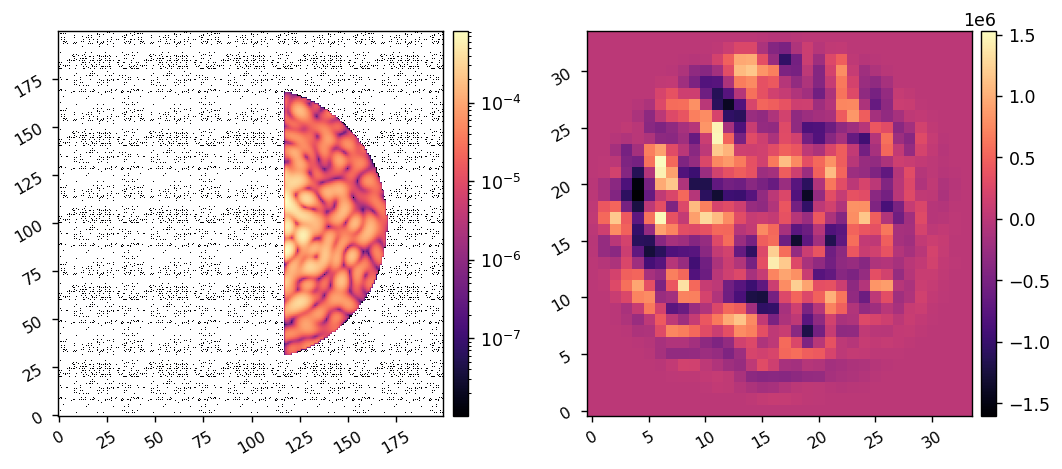

In [11]:
reload(ad_scoob)
del_acts = np.zeros(m.Nacts)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('test_acts.fits')
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2

J, dJ_dA = ad_scoob.val_and_grad(del_acts, 
                                 m,
                                 acts, 
                                 E_ab,
                                 r_cond,
                                 dead_acts=None,
                                 verbose=True,
                                )

current_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2
dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(m.control_mask*current_im, dm_grad, lognorm1=True)

# Does E_ep_k-1 contain the wavefront contribution from the total accumulated DM command?

In [12]:
reload(ad_scoob)

bfgs_tol = 1e-3
bfgs_opts = {
    # 'maxiter':20,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
    'disp':True, 
}

# del_acts0 = np.zeros(m.Nacts)
# acts = np.zeros(m.Nacts)
# E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
# r_cond = 5e-2
# E_target = 0
# E_model_nom = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=False) * m.control_mask)

# res = minimize(ad_scoob.val_and_grad, 
#                 jac=True, 
#                 x0=del_acts0,
#                 args=(m, E_ab, r_cond, E_target, E_model_nom, True), 
#                 method='L-BFGS-B',
#                 tol=bfgs_tol,
#                 options=bfgs_opts,
#                 )


del_acts0 = np.zeros(m.Nacts)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('test_acts.fits')
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-3

res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, None, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

0.33452257679848796 0.0 0.33452257679848796 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.60747D+06
0.00834344157731422 2366863905.3254437 0.33452257679848796 7075348779.103644
0.008003504229270151 432.8202378720278 0.33452257679848796 1293.8685499752896


 This problem is unconstrained.


0.012740374158520754 26.4616088324397 0.33452257679848796 79.14069495687887
0.1327445989402632 2.539392543852458 0.33452257679848796 7.987912709408495
0.8871719294986802 0.2701599460900987 0.33452257679848796 3.4596525193154317
4.56620385156677 0.027670583907905475 0.33452257679848796 13.73262898857187
9.680350247236206 0.0026966353113811355 0.33452257679848796 28.94586958888735
0.1681968175119569 8.469212582920294e-05 0.33452257679848796 0.5030497829124301

At iterate    1    f=  5.03050D-01    |proj g|=  1.51001D+06
0.020486088466086416 4.1635642702491626e-05 0.33452257679848796 0.061364241257637266

At iterate    2    f=  6.13642D-02    |proj g|=  2.71513D+05
0.012645394737850302 4.402752735347528e-05 0.33452257679848796 0.03793293231998425

At iterate    3    f=  3.79329D-02    |proj g|=  1.78249D+05
0.006099492775861043 5.500083341647648e-05 0.33452257679848796 0.018397842286695366

At iterate    4    f=  1.83978D-02    |proj g|=  1.29329D+05
0.004481792337766949 5.974679000643830

In [72]:
del_command = xp.zeros((m.Nact,m.Nact))
del_command[m.dm_mask] = res.x

In [70]:
del_command_dead = xp.zeros((m.Nact,m.Nact))
del_command_dead[m.dm_mask] = res.x

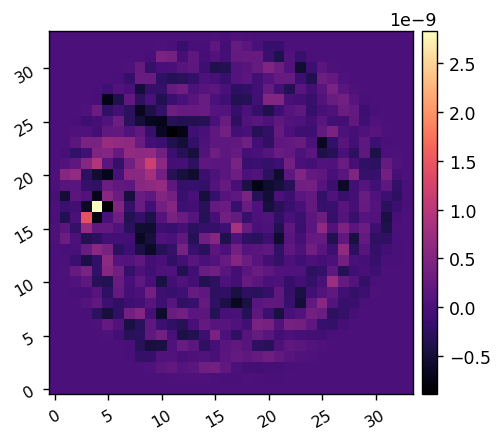

In [73]:
imshow1(del_command - del_command_dead)

6.290383166575555e-05 2.1381882821081377e-07


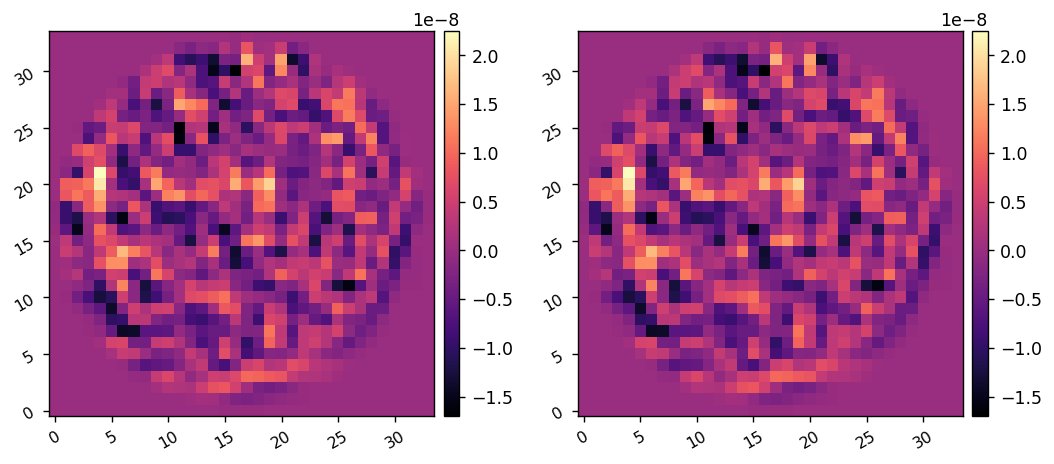

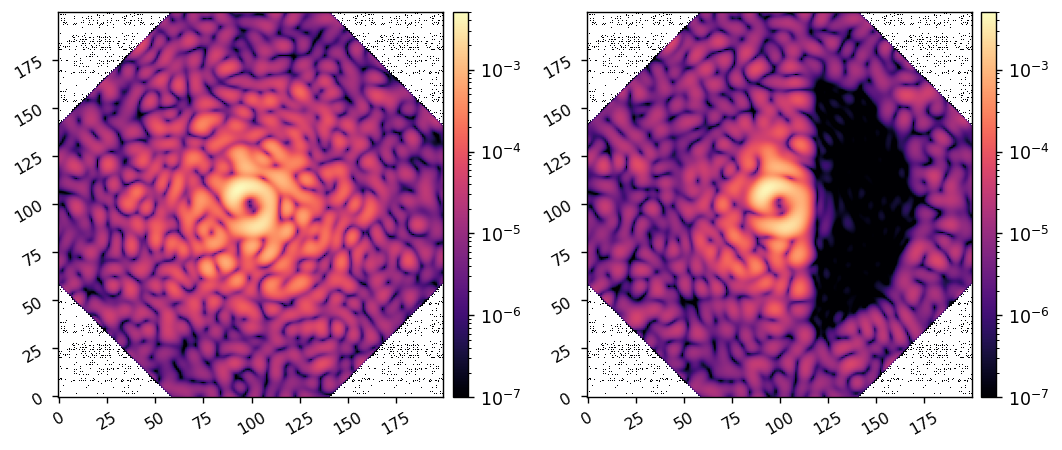

In [13]:
del_command = xp.zeros((m.Nact,m.Nact))
del_command[m.dm_mask] = res.x

total_command = xp.zeros((m.Nact,m.Nact))
total_command[m.dm_mask] = acts + res.x

prev_im = xp.abs(m.forward(acts, use_wfe=True))**2
new_im = xp.abs(m.forward(acts + res.x, use_wfe=True))**2

print(xp.mean(prev_im[m.control_mask]), xp.mean(new_im[m.control_mask]))
imshow2(del_command, total_command)
imshow2(prev_im, new_im, lognorm=True, vmin1=1e-7, vmin2=1e-7, vmax1=5e-3, vmax2=5e-3)

# Test a full EFC run with L-BFGS-B

In [14]:
reload(ad_efc)
reload(ad_scoob)


<module 'scoobpsf.ad_scoob' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/ad_scoob.py'>

In [14]:
all_ims = []
all_efs = []
all_commands = []

In [15]:
bfgs_opts = {
    # 'maxiter':50,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
    'disp':False, 
}

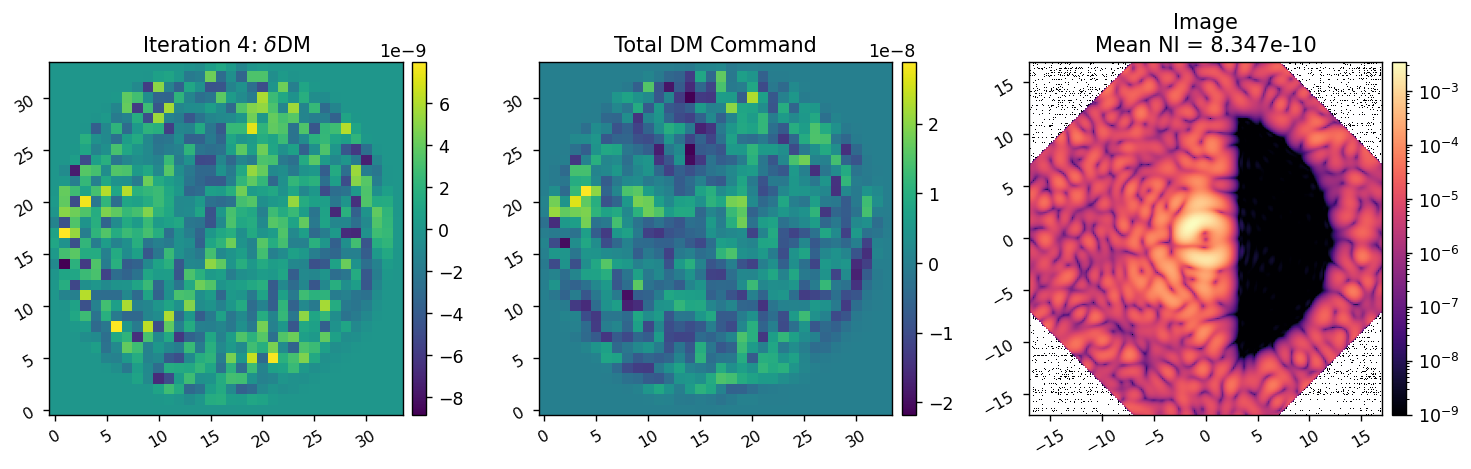

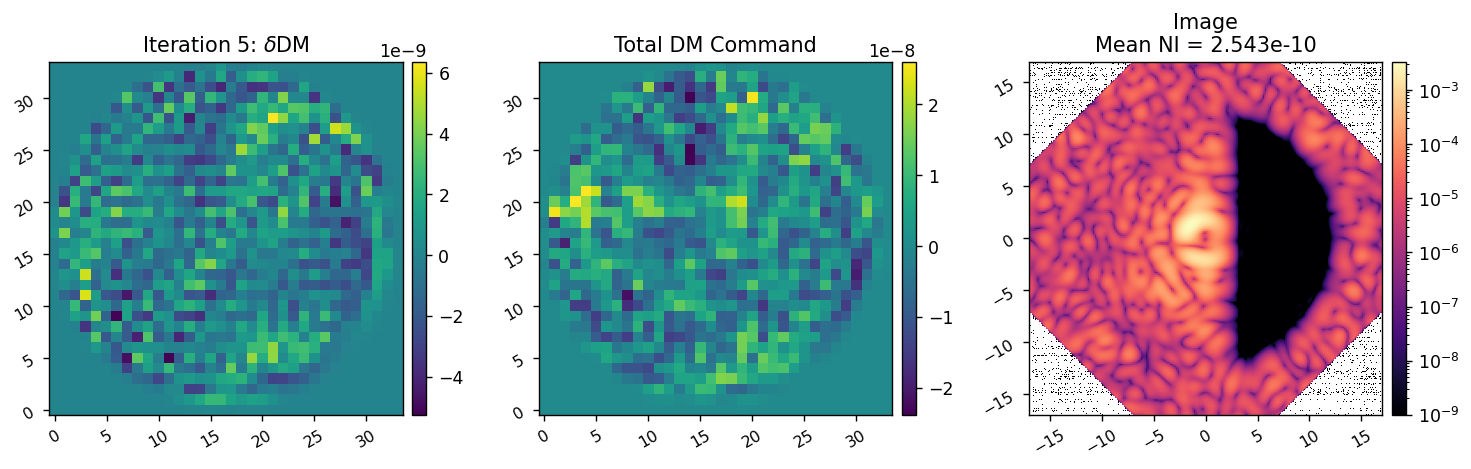

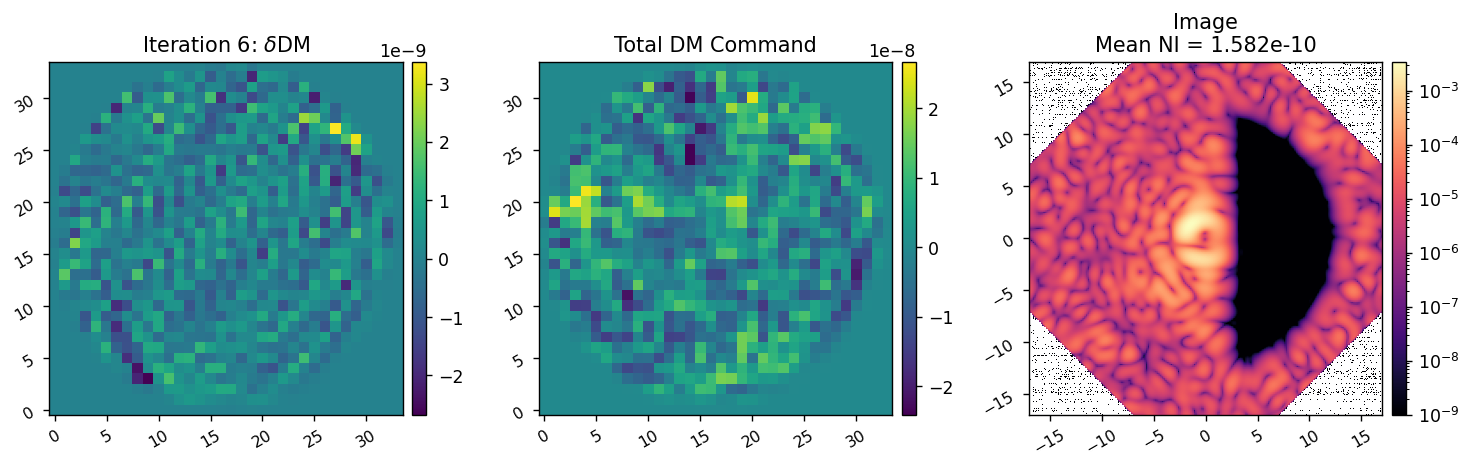

In [17]:
reload(ad_efc)
reload(ad_scoob)

# reg_cond = 1
# reg_cond = 1e-1
reg_cond = 1e-2
# reg_cond = 1e-3
reg_cond = 1e-4
# reg_cond = 1e-5

bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=reg_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

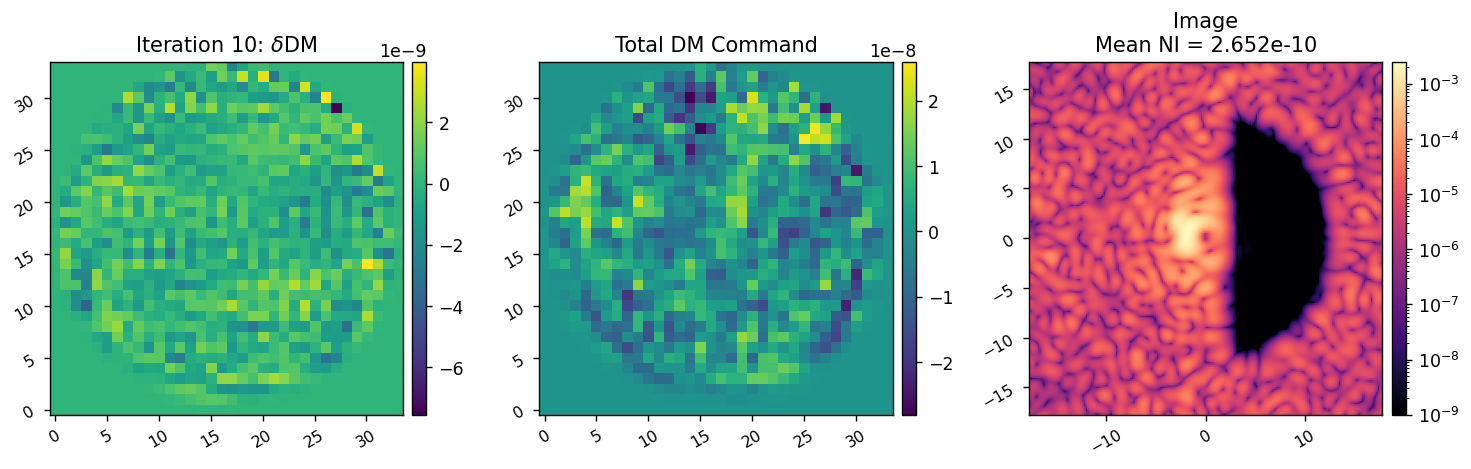

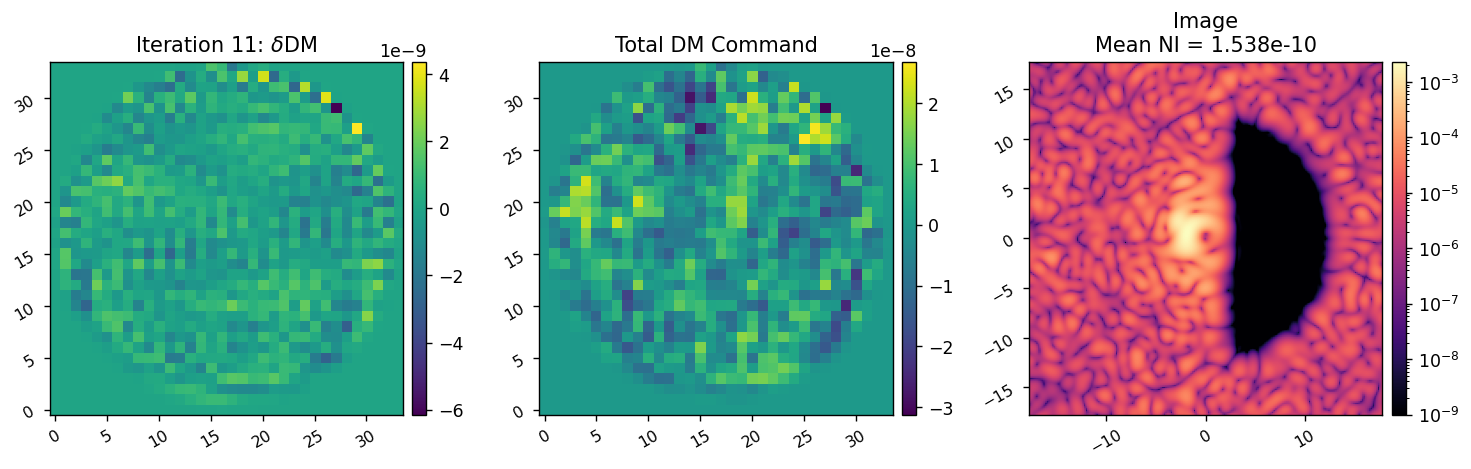

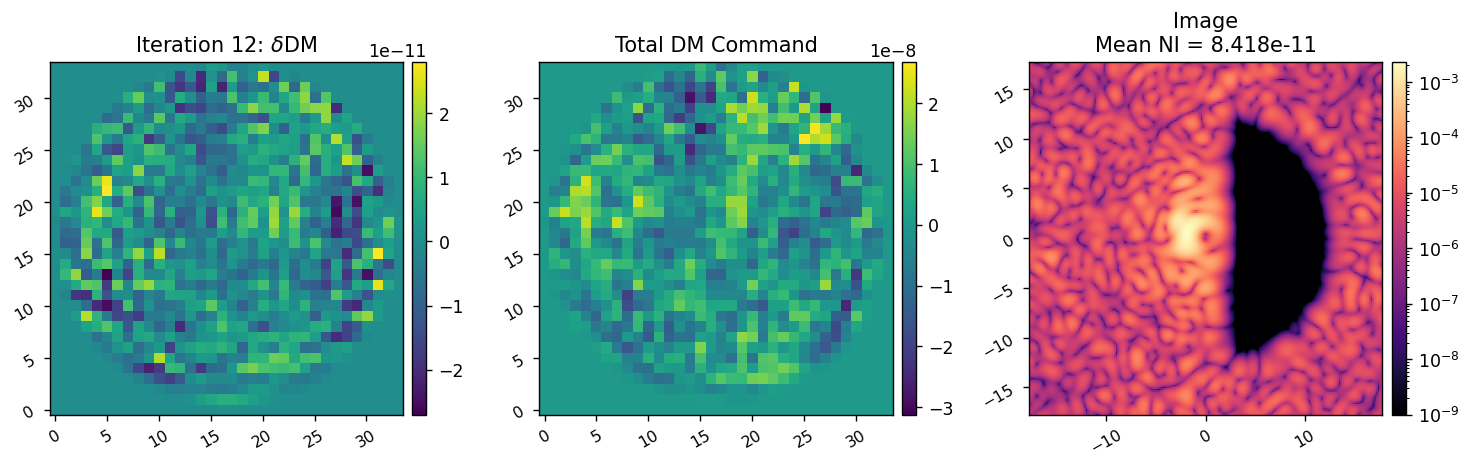

In [26]:
reload(ad_efc)
reload(ad_scoob)

# reg_cond = 1
# reg_cond = 1e-1
reg_cond = 1e-2
# reg_cond = 1e-3
# reg_cond = 1e-4

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=reg_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=0.5,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )